In [1]:
import tensorflow as tf
import torch

# Limit TensorFlow GPU memory usage
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(
                gpu, True
            )  # Prevent TF from hogging memory
    except RuntimeError as e:
        print(e)

# Set PyTorch to use only part of the GPU memory
torch.cuda.set_per_process_memory_fraction(0.5, device=torch.device("cuda:0"))

ModuleNotFoundError: No module named 'tensorflow'

In [72]:
from utils import UNet

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model (make sure this matches the saved model's architecture)
model = UNet(in_channels=3, out_channels=1)

# Load trained weights
model.load_state_dict(torch.load("segmentation_model.pth", map_location=device))

# Set the model to evaluation mode
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_btlnk): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)


In [71]:
from PIL import Image
import torchvision.transforms as transforms


# Define preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


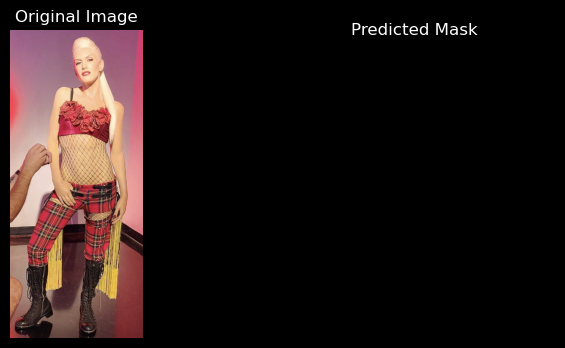

In [73]:
import matplotlib.pyplot as plt
import numpy as np


def predict_mask(image_path):

    # Preprocess the image
    image = preprocess_image(image_path)

    # Run the model
    with torch.no_grad():
        output = model(image)

    # Convert output to binary mask
    mask = output.squeeze().cpu().numpy()  # Remove batch and channel dimensions
    mask = (mask > 0.5).astype(np.uint8)  # Apply threshold to get binary mask

    print(mask)

    # Display results
    plt.figure(figsize=(8, 4))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title("Original Image")
    plt.axis("off")

    # Show predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


# Example usage
predict_mask("Screenshot.png")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


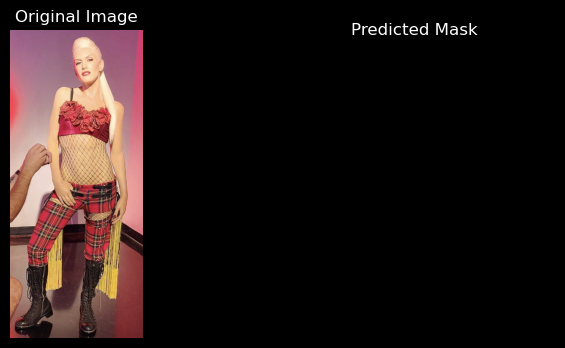

AssertionError: Error: mask is None

In [67]:
import cv2


def overlay_mask(image_path, mask):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print(image)

    # Resize mask to match image size
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Create overlay
    overlay = image.copy()
    overlay[mask_resized == 1] = [255, 0, 0]  # Red overlay on masked areas

    # Blend images
    try:
        mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
    except Exception as e:
        print(f"Error resizing mask: {e}")

    # Show result
    plt.figure(figsize=(6, 6))

    plt.title("Image with Overlayed Mask")
    plt.axis("off")
    plt.show()


# Example usage
image = "Screenshot.png"
mask = predict_mask(image)  # Get mask
assert mask is not None, "Error: mask is None"
assert isinstance(mask, np.ndarray), "Error: mask is not a NumPy array"
overlay_mask(image, mask)
print(mask.shape)